In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

import md_lvm
importlib.reload(md_lvm)
import saem
importlib.reload(saem)

<module 'saem' from '/Users/francescacrucinio/Documents/MD_LVM/saem.py'>

In [2]:
nodes = 100
pi = np.array([0.6, 0.4])
probs = np.array([[0.25, 0.1], [0.1, 0.2]])

In [3]:
# def sbm_sample(pi, nu, nodes):
#     # block allocation
#     x = np.random.choice(np.arange(len(pi)), nodes, p=pi)
#     # adjacency matrix 
#     A = np.zeros((nodes, nodes))
#     for i in range(nodes):
#         A[i, np.delete(np.arange(nodes), i)] = np.random.binomial(1, p = probs[x[i], np.delete(x, i)], size = nodes-1)
#     return A, x

In [4]:
# y, res_z = sbm_sample(pi, probs, nodes)
# # y = np.loadtxt("adj.txt")

In [5]:
z = np.loadtxt("z.txt")
y = np.loadtxt("adj.txt")

In [6]:
th0 = np.array([0.3, 0.3, 0.3, 0.3, 0.3])  # Initial parameter guess.
X0 = np.random.binomial(1, 0.5, nodes)  # Initial particle cloud.

In [7]:
Niter = 500
Nrep = 5
N = nodes
gamma = 0.02
theta_saem_est = np.zeros((Nrep, 5))
runtime_saem = np.zeros(Nrep)
ari_saem = np.zeros(Nrep)
theta_md_est = np.zeros((Nrep, 5))
ari_md = np.zeros(Nrep)
runtime_md = np.zeros(Nrep)

In [8]:
for j in range(Nrep):
    start = time.time()
    # SAEM
    z_iter = np.zeros([Niter, nodes])
    s1_iter = np.zeros(Niter)
    s2_iter = np.zeros((Niter, 4))
    s3_iter = np.zeros((Niter, 4))
    theta_saem = np.zeros((Niter, th0.size))
    n = 0
    z_iter[n, :] =  np.random.binomial(1, 0.5, size = nodes)
    theta_saem[n,:] = th0
    for n in range(1, Niter):
        delta = 1/n
        z_iter[n, :] = saem.sbm_saem_proposal(y, z_iter[n-1, :], theta_saem[n-1,:])
        s1_update, s2_update, s3_update = saem.sbm_saem_sufficient_stat(z_iter[n, :], y)
        s1_iter[n] = s1_iter[n-1] + delta*(s1_update - s1_iter[n-1])
        s2_iter[n, :] = s2_iter[n-1, :] + delta*(s2_update - s2_iter[n-1, :])
        s3_iter[n, :] = s3_iter[n-1, :] + delta*(s3_update - s3_iter[n-1, :])
        theta_saem[n,:] = saem.sbm_saem_mle(s1_iter[n], s2_iter[n,:], s3_iter[n,:], nodes)
    ari_saem[j] = saem.sbm_ari(z-1, z_iter[-1,:])
    theta_saem_est[j, :] = theta_saem[-1,:]
    end = time.time()
    runtime_saem[j] = end-start
    # SMC-LVMs
    start = time.time()
    theta_md, x_md, W = md_lvm.md_sbm_fast(y, gamma, Niter, N, th0, X0)
    end = time.time()
    runtime_md[j] = end-start
    ari_md[j] = saem.sbm_ari(z-1, x_md[-1,:])
    theta_md_est[j, :] = theta_md[-1,:]
    print(j)

0
1
2
3
4


In [9]:
np.mean(ari_saem), np.mean(ari_md)

(0.7554747474747475, 0.860848484848485)

In [10]:
np.mean(runtime_saem), np.mean(runtime_md)

(38.95623345375061, 102.50589027404786)

In [12]:
theta_saem_est, theta_md_est

(array([[0.42146293, 0.1867626 , 0.12797724, 0.11486839, 0.21946691],
        [0.47945892, 0.25792881, 0.1021332 , 0.11809259, 0.18768296],
        [0.52633267, 0.24766893, 0.09931943, 0.11111415, 0.20125409],
        [0.35480962, 0.14250042, 0.1722092 , 0.1353741 , 0.18597611],
        [0.52210421, 0.25068388, 0.09736222, 0.11016297, 0.20157458]]),
 array([[0.55431564, 0.23525233, 0.10435922, 0.11660999, 0.19788041],
        [0.54530207, 0.24246199, 0.09842128, 0.10855397, 0.20682939],
        [0.53997371, 0.24330593, 0.09933175, 0.11106793, 0.20295609],
        [0.5308103 , 0.24489859, 0.1001208 , 0.1116264 , 0.20337422],
        [0.53608305, 0.24639253, 0.09712495, 0.10829456, 0.20458207]]))

In [13]:
rse_saem = np.zeros((Nrep, 5))
se_saem = np.zeros((Nrep, 5))
switched_saem = np.zeros((Nrep))
rse_md = np.zeros((Nrep, 5))
se_md = np.zeros((Nrep, 5))
switched_md = np.zeros((Nrep))
for j in range(Nrep):
    se_saem[j, :], rse_saem[j, :], switched_saem[j] = saem.se_sbm(theta_saem_est[j], pi, probs)
    se_md[j, :], rse_md[j, :], switched_md[j] = saem.se_sbm(theta_md_est[j], pi, probs)
    print(j)

0
1
2
3
4


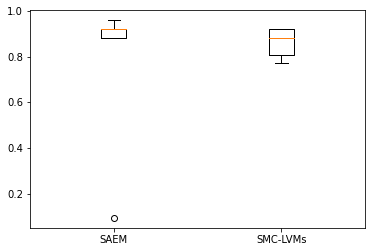

In [28]:
plt.boxplot([ari_saem, ari_md], labels = ["SAEM", "SMC-LVMs"]);
# plt.yscale('log')

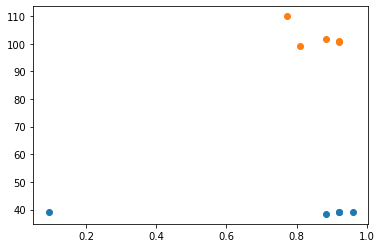

In [42]:
plt.scatter(ari_saem, runtime_saem);
plt.scatter(ari_md, runtime_md)

In [79]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = np.repeat(prop_cycle.by_key()['color'][:2], 4)
colors 

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e',
       '#ff7f0e', '#ff7f0e'], dtype='<U7')

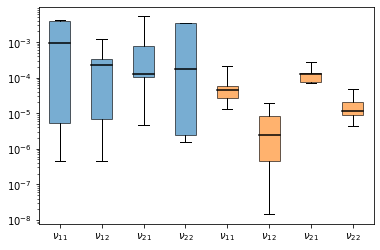

In [80]:
boxp = plt.boxplot(np.concatenate((se_saem[:, 1:], se_md[:, 1:]), axis = 1), whis = 15, patch_artist=True, labels = [f"${{\\nu_{{11}}}}$", f"${{\\nu_{{12}}}}$", f"${{\\nu_{{21}}}}$", 
                                                                                f"${{\\nu_{{22}}}}$", f"${{\\nu_{{11}}}}$", f"${{\\nu_{{12}}}}$", f"${{\\nu_{{21}}}}$", 
                                                                                f"${{\\nu_{{22}}}}$"]);
plt.yscale('log')
for patch, color in zip(boxp['boxes'], colors):
    patch.set_alpha(0.6)
    patch.set_facecolor(color)
for median in boxp['medians']:
    median.set(color='k', linewidth=1.5)

In [84]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

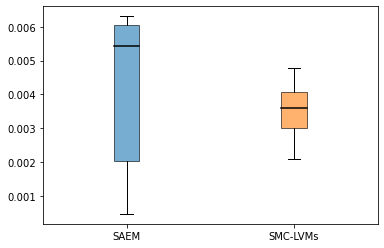

In [85]:
i = 0
boxp = plt.boxplot([se_saem[:, i], se_md[:, i]], whis = 15, patch_artist=True, labels = ["SAEM", "SMC-LVMs"]);
for patch, color in zip(boxp['boxes'], colors):
    patch.set_alpha(0.6)
    patch.set_facecolor(color)
for median in boxp['medians']:
    median.set(color='k', linewidth=1.5)
# plt.yscale('log')

In [16]:
np.sum(switched_saem)/Nrep, np.sum(switched_md)/Nrep

(0.6, 0.0)